In [1]:
from __future__ import print_function 
import torch 
import torch.nn as nn 
import torch.utils.data 
from torch.autograd import Variable 
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import time
from submodule import *
from preprocess import *
from dataloader import listflowfile as lt
from dataloader.KITTILoader import *
from dataloader.KITTIloader2015 import *

In [2]:
class PSMNet(nn.Module):
    def __init__(self, maxdisp):
        super(PSMNet, self).__init__()
        self.maxdisp = maxdisp
        self.feature_extraction = feature_extraction()
        self.dres0 = nn.Sequential(convbn_3d(64, 32, 3, 1, 1),
                                   nn.ReLU(inplace=True),
                                   convbn_3d(32, 32, 3, 1, 1),
                                   nn.ReLU(inplace=True))

        self.dres1 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                   nn.ReLU(inplace=True),
                                   convbn_3d(32, 32, 3, 1, 1)) 

        self.dres2 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                   nn.ReLU(inplace=True),
                                   convbn_3d(32, 32, 3, 1, 1))
 
        self.dres3 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                   nn.ReLU(inplace=True),
                                   convbn_3d(32, 32, 3, 1, 1)) 

        self.dres4 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                   nn.ReLU(inplace=True),
                                   convbn_3d(32, 32, 3, 1, 1)) 
 
        self.classify = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1,bias=False))


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1]*m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()


    def forward(self, left, right):

        refimg_fea     = self.feature_extraction(left)
        targetimg_fea  = self.feature_extraction(right)
 
        #matching
        cost = Variable(torch.FloatTensor(refimg_fea.size()[0], refimg_fea.size()[1]*2, self.maxdisp/4,  refimg_fea.size()[2],  refimg_fea.size()[3]).zero_(), volatile= not self.training).cuda()

        for i in range(self.maxdisp/4):
            if i > 0 :
             cost[:, :refimg_fea.size()[1], i, :,i:]   = refimg_fea[:,:,:,i:]
             cost[:, refimg_fea.size()[1]:, i, :,i:] = targetimg_fea[:,:,:,:-i]
            else:
             cost[:, :refimg_fea.size()[1], i, :,:]   = refimg_fea
             cost[:, refimg_fea.size()[1]:, i, :,:]   = targetimg_fea
        cost = cost.contiguous()

        cost0 = self.dres0(cost)
        cost0 = self.dres1(cost0) + cost0
        cost0 = self.dres2(cost0) + cost0 
        cost0 = self.dres3(cost0) + cost0 
        cost0 = self.dres4(cost0) + cost0

        cost = self.classify(cost0)
        cost = F.upsample(cost, [self.maxdisp,left.size()[2],left.size()[3]], mode='trilinear')
        cost = torch.squeeze(cost,1)
        pred = F.softmax(cost)
        pred = disparityregression(self.maxdisp)(pred)
        return pred

In [ ]:
if __name__=='__main__':
    max_disp = 192
    datapath = '/media/mnt1/dataset/Kitti_2015/training/'
    epochs = 20
    model = PSMNet(max_disp)
    model = model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    print(model)

## Get dataset string
### data path 내에 있는 left image, right image, disparity 등의 string을 가져온다.

In [4]:
    all_left_img, all_right_img, all_left_disp, test_left_img, test_right_img, test_left_disp = dataloader(datapath)
    print('left image string:', all_left_img[0])
    print('right image string: ', all_right_img[0])
    print('left disparity string: ', all_left_disp[0])
    print('test left image string: ',test_left_img[0])
    print('test right image string: ', test_right_img[0])

left image string: /media/mnt1/dataset/Kitti_2015/training/image_2/000009_10.png
right image string:  /media/mnt1/dataset/Kitti_2015/training/image_3/000009_10.png
left disparity string:  /media/mnt1/dataset/Kitti_2015/training/disp_occ_0/000009_10.png
test left image string:  /media/mnt1/dataset/Kitti_2015/training/image_2/000136_10.png
test right image string:  /media/mnt1/dataset/Kitti_2015/training/image_3/000136_10.png


## Define dataloader
### image string정보를 사용하여 dataloader를 정의한다. 

In [5]:
    KITTI_dataset = myImageFloder(all_left_img,all_right_img,all_left_disp, True)
    TrainImgLoader = torch.utils.data.DataLoader(KITTI_dataset, 
         batch_size= 12, shuffle= True, num_workers= 8, drop_last=False)
    print(TrainImgLoader)

## Check KITTI dataset data
### 우리가 정의한 KITTI dataset 정보를 사용하여 image들을 plot 해봅니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


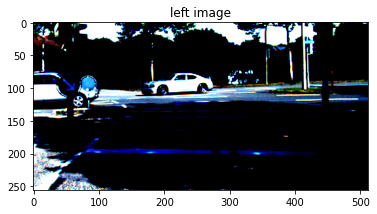

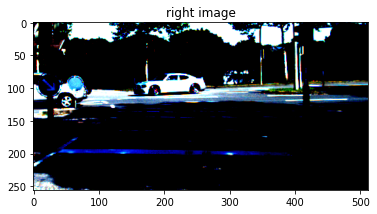

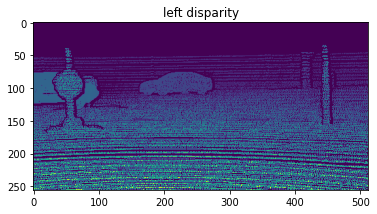

In [6]:
    left_img, right_img, left_disp = KITTI_dataset.__getitem__(0)
    plt.figure()
    plt.title('left image')
    plt.imshow(left_img.detach().cpu().numpy().transpose(1,2,0))
    plt.figure()
    plt.title('right image')
    plt.imshow(right_img.detach().cpu().numpy().transpose(1,2,0))
    plt.figure()
    plt.title('left disparity')
    plt.imshow(left_disp)

In [ ]:
    model.train()
    for epoch in range(0, epochs):
        print('This is %d-th epoch' %(epoch))
        for batch_idx, (imgL_crop, imgR_crop, disp_crop_L) in enumerate(TrainImgLoader):
            imgL_crop, imgR_crop, disp_crop_L = imgL_crop.cuda(), imgR_crop.cuda(), disp_crop_L.cuda()
            start_time = time.time()
            import pdb; pdb.set_trace()
            output = model(imgL_crop, imgR_crop)
            output = torch.squeeze(output,1)
            loss = F.smooth_l1_loss(output[mask], disp_true[mask], size_average=True)
            loss.backward()
            optimizer.step()
            print('Iter %d training loss = %.3f , time = %.2f' %(batch_idx, loss, time.time() - start_time))
        print('epoch %d total training loss = %.3f' %(epoch, total_train_loss/len(TrainImgLoader)))

This is 0-th epoch
> <ipython-input-7-8e9e791260e7>(8)<module>()
-> output = model(imgL_crop, imgR_crop)
(Pdb) imgL_crop.type()
'torch.cuda.FloatTensor'
(Pdb) model.is_cuda()
*** AttributeError: 'PSMNet' object has no attribute 'is_cuda'
(Pdb) model(imgL_crop, imgR_crop)
*** RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
